# ARSHIYA IRAM AQUEEL AHMED
### DATA SCIENCE AND BUSINESS ANALYTICS INTERN @ THE SPARKS FOUNDATION
## GRIPMARCH23 
#### Dataset: (https://bit.ly/2TK5Xn5)
## TASK-FOUR...EXPLORATORY DATA ANALYSIS - TERRORISM
#### Perform ‘Exploratory Data Analysis’ on dataset ‘Global Terrorism’
###### This is a publically available dataset, and as a part of Fellowship.ai challenge participants are supposed to build a model that can predict the group responsible for an attack given the information about the attack like attack-type, weapons used, description of attack, location etc. This notebook showcases the step-by-step approach to the problem including visualization and developing the predictive model. Lets start with importing libraries.

In [33]:
import pandas as pd
import numpy as np
import folium
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import warnings
from PIL import Image
import re
import squarify
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')

### 1. Getting the data ready for Classification
###### Lets start with importing the dataset.

In [34]:
mask = np.array(Image.open("/content/sample_data/wordcloud.png")) #An image file to mask the wordcloud
data = pd.read_csv("/content/sample_data/globalterrorismdb_0718dist.csv",encoding='ISO-8859-1')

In [35]:
data.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


### 1.1 Lot of "Unknown" class
###### The dataset contains a huge number of "Unknown"s in Group Name. Abou 46%

In [36]:
len(data[data['gname']=="Unknown"])/len(data)*100

45.561970598433604

###### These rows should be removed due to two reasons: 1.) They have a huge proportion in dataset 2.) Learning them doesn't make any sense.

### 1.2 Huge number of classes
###### Lets try to get an idea how the distribution of classes look like.

In [37]:
len(data['gname'].unique())

3537

###### As you can see, there are 3,453 unique classes i.e., different terrorist groups in the dataset. It is very difficult task to plot its histogram and visualize. Rather lets sample it and try to see if we get any idea about the distribution of classes in dataset.

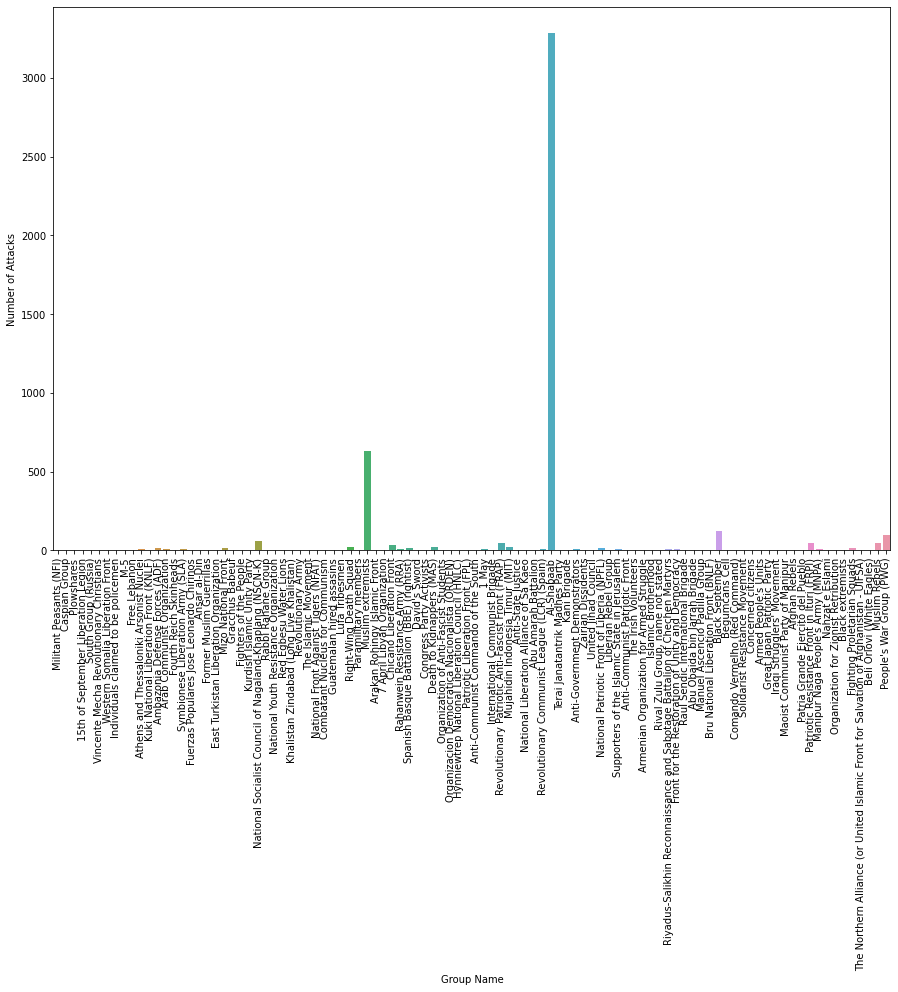

In [38]:
plt.subplots(figsize=(15,10))
no_of_classes = data['gname'].value_counts(sort=True)
no_of_classes_sample = no_of_classes.sample(n=100)
p = sns.barplot(no_of_classes_sample.index,no_of_classes_sample)
p.set(xlabel="Group Name",ylabel="Number of Attacks")
p.set_xticklabels(no_of_classes_sample.index,rotation=90)
plt.show()

###### The distribution of classes is highly skewed. There are many classes that only appear once in entire data (These are outliers). They need to be removed as the learning algorithm won't be able to learn it. There are many classes to remove, but how to decide which to remove and which not. Well, lets decide a threshold value of "number of occurrence" of a class. Example threshold = 200, any class having number of occurances less than class_freq[threshold] will be removed. We can increase or decrease this value according to need, ofcourse prediciton value will differ in each case. Increasing the threshold value will decrease accuracy score, as more and more outliers will be added to training set and decreasing will vice versa increase the accuracy score. The value of threshold can be anything, for now lets choose 500

###### Above value of threshold will be used in the prediction model.

In [39]:
threshold = 500
class_freq = data[data['gname']!='Unknown']['gname'].value_counts() #Frequency table of Terrorist groups, sorted by default in descending order
class_freq[threshold] # this value is frequency of class at 500th index. i.e., 11

13

### 1.3 Cleaning the data
###### Below function takes "threshold" value as parameter and filters out the classes having frequency less than class_freq [threshold] . The model doesn't expectes all the attributes given in data. It takes following attributes: iyear, imonth, iday, extended, country, region, latitude, longitude, vicinity, crit1 , crit2, crit3, doubtterr, attacktype1, targtype1, weaptype1

###### The rows having crit1, crit2 and crit3 != 1 are removed because we are looking for attacks that match requirements as "terrorist attacks". The function then randomizes the data and splits into groups of train and test.

In [40]:
data = data[data['gname']!='Unknown']# Remove "Unknown" groups, they contribut almost half to data.

In [41]:
def prep(data,threshold):
    l = LabelEncoder()
    class_freq = data[data['gname']!='Unknown']['gname'].value_counts()  # Count frequency of each groups
    data['weaptype1_txt'] = data['weaptype1_txt'].apply(lambda x: 'Vehicle' if x=='Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)' else x)
    data = data[data['gname']!='Unknown'] # Remove "Unknown" groups, they contribut more than
    data['provstate'] = data.apply(lambda row: row['city'] if pd.isnull(row['provstate']) else row['provstate'], axis=1)
    data = data.loc[:,data.columns[[1,2,3,5,7,9,11,13,14,16,19,20,21,22,28,34,58,81]]] #Select only intereseted columns
    data = data[(data.crit1==1) & (data.crit2==1) & (data.crit3 ==1) & (data.doubtterr==0)] #Keep rows that are terrorist attacks for sure
    data = data[data['gname'].isin(class_freq.index[:threshold])] #Remove classes having frequency less than class_frequency[threshold]
    data = data.sample(frac=1) #Randomize dataset
    data = data.dropna() 
    data['provstate'] = l.fit_transform(data['provstate']) # Encode all states
    data['gname'] = l.fit_transform(data['gname']) #Encode all groups
    y = data['gname']
    data = data.drop('gname',axis=1)
    train = data[:round(0.85*len(data))] #Split train and test data
    y_train = y[:round(0.85*len(data))]
    test = data[round(0.85*len(data)):]
    y_test = y[round(0.85*len(data)):]
    return train, y_train, test, y_test

In [42]:
train, y_train, test, y_test = prep(data,threshold)

### 2. Exploratory Data Analysis
##### 2.1 Word Cloud
###### Lets get the idea about the text data we have, as you can see the most of the addnotes have words "casualty", "conflict", "attack", "victims"

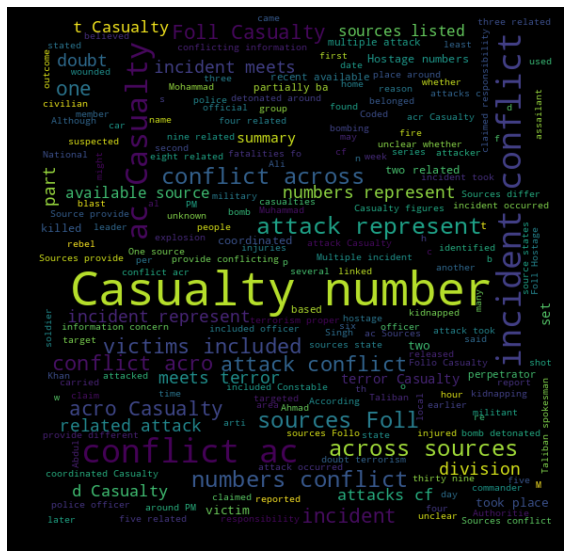

In [43]:
# Show a word-cloud
text = data['addnotes']
def get_wordcloud(text):
    text = text.dropna()
    text = text.to_string()
    text = re.sub(' +',' ',text)
    wordcloud = WordCloud(mask = mask).generate(text)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0,y=0)
    plt.show()
get_wordcloud(text)

### 2.2 World Map, number of attacks for year 2016

In [44]:
def worldMap(data,year):
    d = data[data['iyear']==year]
    d2 = pd.DataFrame(d.groupby(['country_txt'])['country_txt'].count())
    d2.columns = ['count']
    d2.reset_index(inplace=True)
    world_geo = r'C:/Users/Kavan/Desktop/New folder/world.json'
    m = folium.Map(location=[20,0],zoom_start=2)
    m.choropleth(world_geo,name='choropleth',
                 data=d2,columns=['country_txt','count'],
                 key_on='feature.properties.name',
                 fill_color = 'Reds',
                 threshold_scale =[1,200,500,800,1200,1400],
                 legend_name ="Number of Attacks in each country for " + str(year))
    folium.LayerControl().add_to(m)
    m.save("/content/sample_data/map.png")

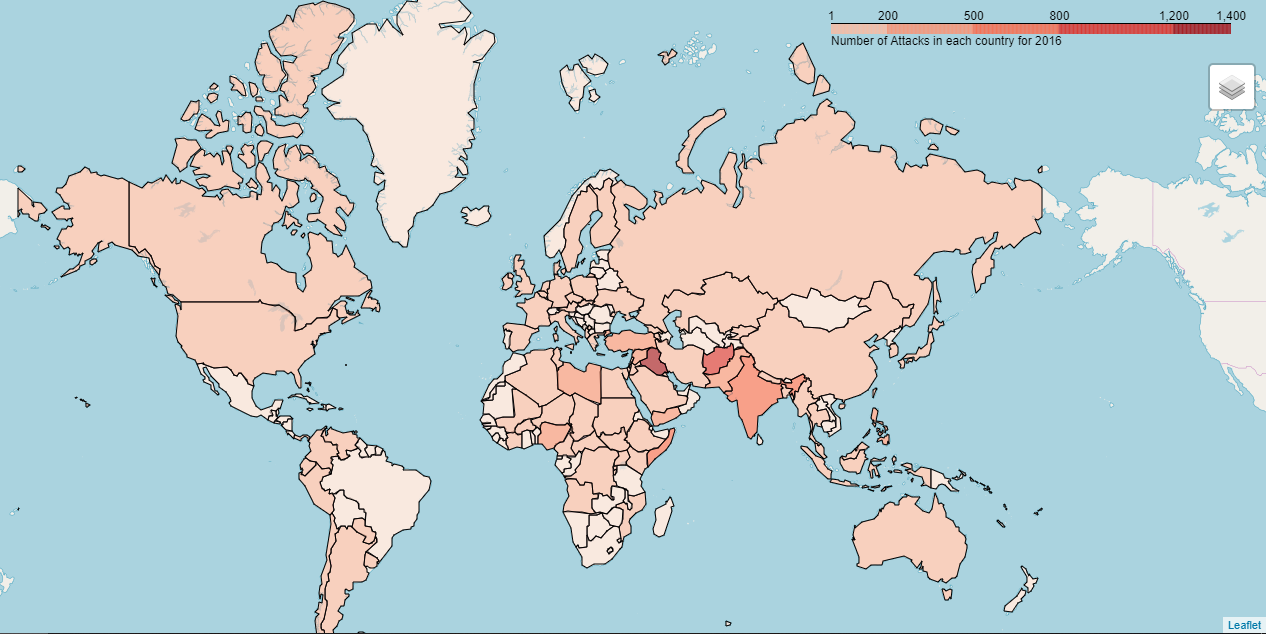

In [45]:
from IPython.display import Image
Image("/content/sample_data/map.png")

### 2.3 Number of kills from 1970 to 2016 by terrorist attacks globally.
###### It can be seen from below graph that number of kills in 2001 was significantly higher than its left and right neighbours. It is because about 3000 deaths have been reported during the attacks of 9/11. The number decreases after that maybe because of decreasing terrorist activity due to subsequent measures taken by U.S. government and rest of the world. It rose during second decade of 21st century due to birth and rise of infamous terrorist groups like ISIS, ISIL, Taliban etc.

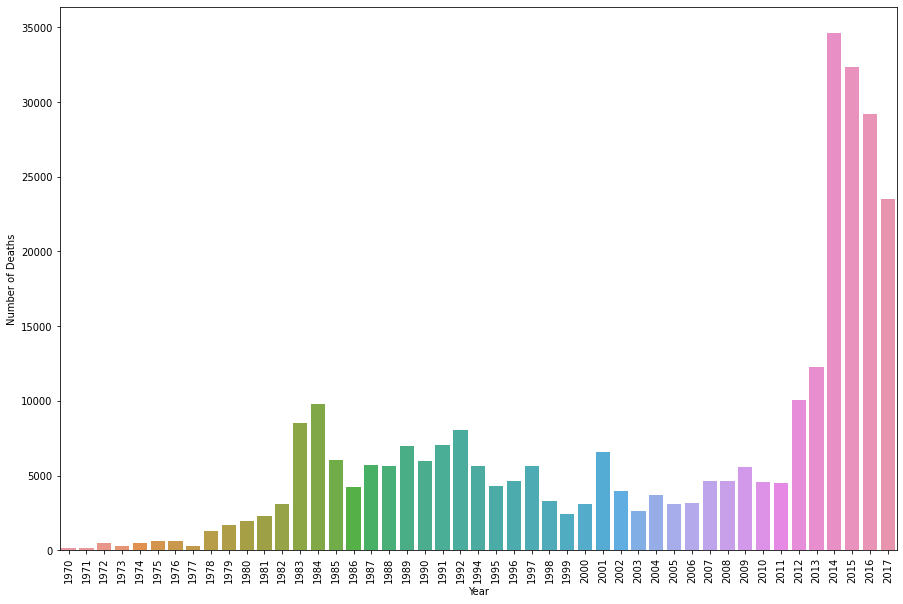

In [46]:
data['nkill'].fillna(0)
no_of_kills = data.groupby('iyear')['nkill'].sum()
plt.subplots(figsize=(15,10))
plot1 = sns.barplot(no_of_kills.index,no_of_kills)
plot1.set_xlabel("Year")
plot1.set_ylabel("Number of Deaths")
plot1.set_xticklabels(no_of_kills.index,rotation=90)
plt.show()

###### Above insight can be verified by below graph, which shows the number of kills in Middle East region. It has been growing ever since 2010 i.e., during increasing conflicts in Syria, "2011 March - Security forces shoot dead protestors in southern city of Deraa demanding release of political prisoners, triggering violent unrest that steadily spread nationwide over the following months." (https://www.bbc.com/news/world-middle-east-14703995)



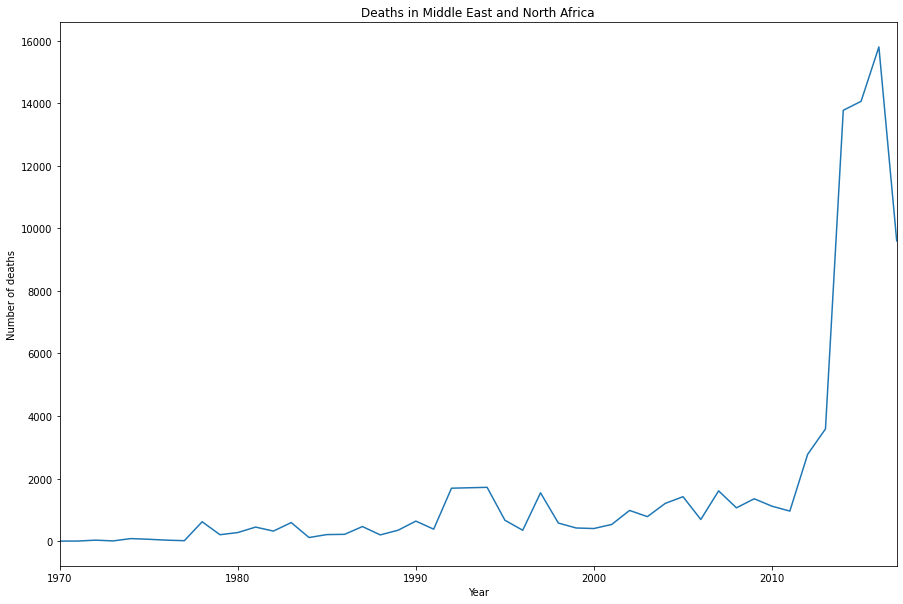

In [47]:
plt.subplots(figsize=(15,10))
d = data[data['region_txt']=='Middle East & North Africa']
d3 = pd.DataFrame(d.groupby(['iyear'])['nkill'].sum())
d3.reset_index(inplace=True)
d3['dummy']=0
l = sns.tsplot(time="iyear",value="nkill",data=d3,unit="dummy")
l.set_title("Deaths in Middle East and North Africa")
l.set_xlabel("Year")
l.set_ylabel("Number of deaths")
plt.show(l)

### 2.4 An Interesting Insight : Number of attacks by Taliban each quarter, 2012-2016


In [48]:
def attacks_per_month(data,gname,year):
    data2 = data[(data['gname']==gname) & (data['iyear']==year)]
    attacks_month = data2.groupby(['imonth'])['nkill'].sum()
    quarters = pd.Series([sum(attacks_month.iloc[0:3]),sum(attacks_month.iloc[3:6]),sum(attacks_month.iloc[6:9]),sum(attacks_month.iloc[9:])],index=[1,2,3,4])
    plot2 = sns.barplot(quarters.index ,quarters)
    plot2.set_xlabel('Quarter')
    plot2.set_ylabel('Number of Attacks')
    plot2.set_title(gname + " in "+str(year))
    plt.show()

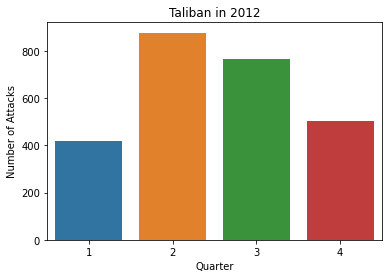

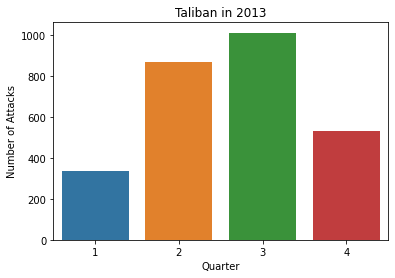

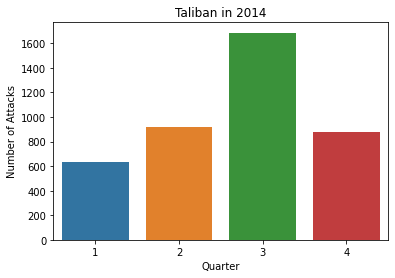

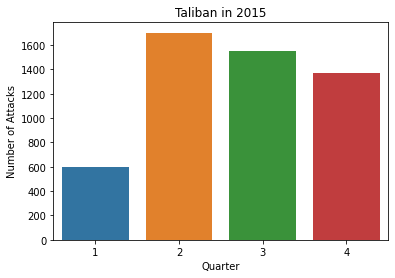

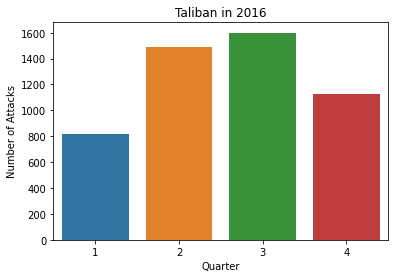

In [49]:
for i in range(2012,2017):
    attacks_per_month(data,"Taliban",i)

###### Looks like Taliban has been following a fashion of attacks, since 2012, its activities has been minimum in first quarter of each year and most active during 2nd and 3rd quarters. (This is not the case before 2012)

### 2.5 Total number of attacks in every year by region

In [50]:
def attacks_region(data):
    plt.subplots(figsize=(15,10))
    d = data.groupby(['region_txt','iyear'])['iyear'].count()
    d = pd.DataFrame(d)
    d.reset_index(level=0,inplace=True)
    d.columns = ['Region','Number of Attacks']
    d.reset_index(level=0,inplace=True)
    d['dummy']=0
    color_set = ["#e82727","#ff8649","#ffc549","#fced20","#8fe222","#22e28e","#22e2db","#1f85c4","#361599","#d11fce","#00ff99","#fa97fc"]
    t = sns.tsplot(time='iyear',value='Number of Attacks',condition='Region',data=d,unit='dummy',color = sns.color_palette(color_set))
    t.set_xlabel("Year")
    plt.show()

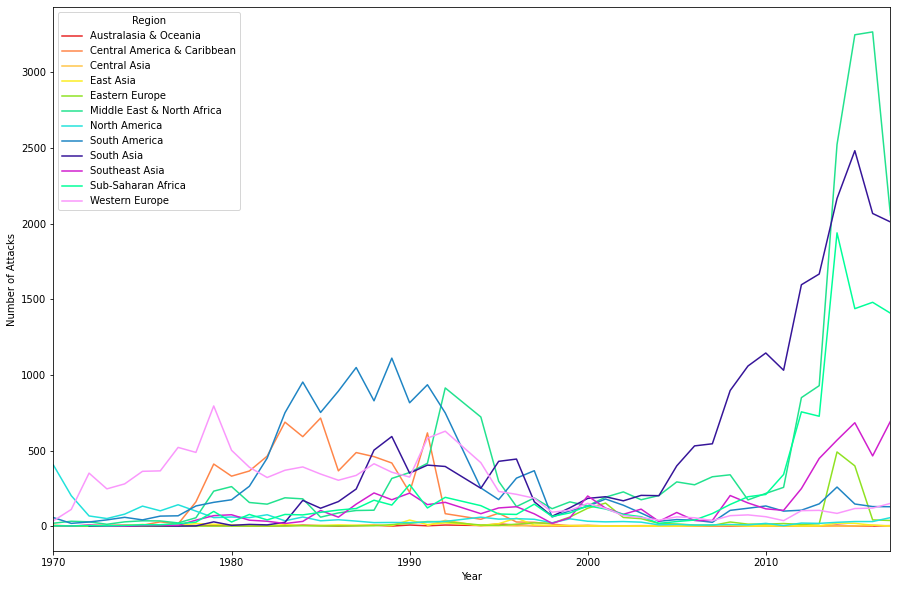

In [51]:
attacks_region(data)

###### Looking at above graph East Asia seems to be the safest region, least influenced by terrorist groups

### 2.6 Activity of top 10 most infamous terrorist groups.

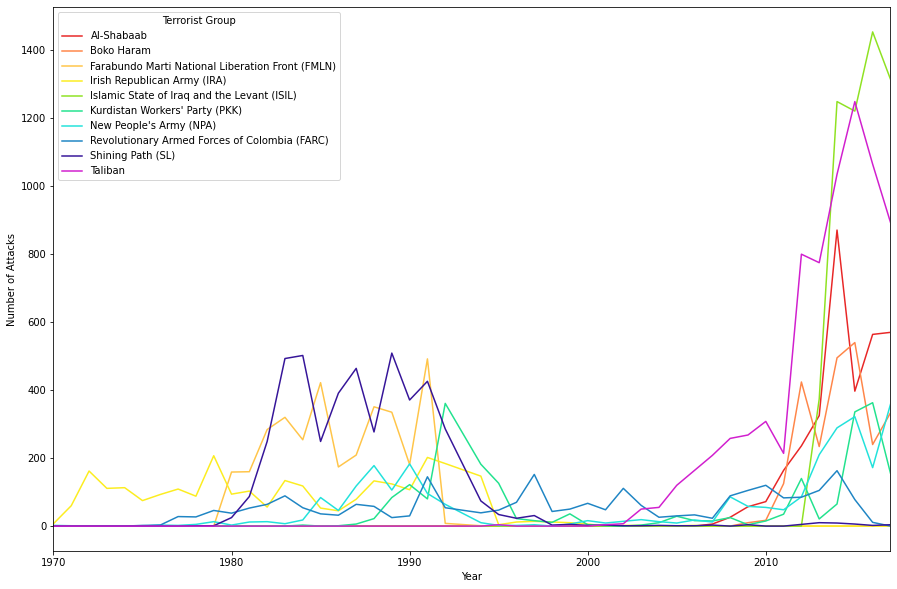

In [52]:
def attacks_terr(data):
    plt.subplots(figsize=(15,10))
    d = pd.DataFrame(data.groupby(['gname','iyear'])['iyear'].count())
    d.columns=['Number_of_Attacks']
    d.reset_index(inplace=True)
    d2 = d.loc[d['gname'].isin(data['gname'].value_counts().sort_values(ascending=False).index[:10])]
    d2 = d2.pivot(index='gname',columns='iyear',values='Number_of_Attacks').fillna(0)
    d2 = pd.DataFrame(d2.unstack(level=0))
    d2.reset_index(inplace=True)
    d2.columns=['Year','Terrorist Group','Number of Attacks']
    color_set = ["#e82727","#ff8649","#ffc549","#fced20","#8fe222","#22e28e","#22e2db","#1f85c4","#361599","#d11fce"]
    d2['dummy']=0
    sns.tsplot(time='Year',value='Number of Attacks',condition='Terrorist Group',data=d2,unit='dummy',color = sns.color_palette(color_set))
    plt.show()
attacks_terr(data)

2.7 Which weapon type is Taliban's most favorite?

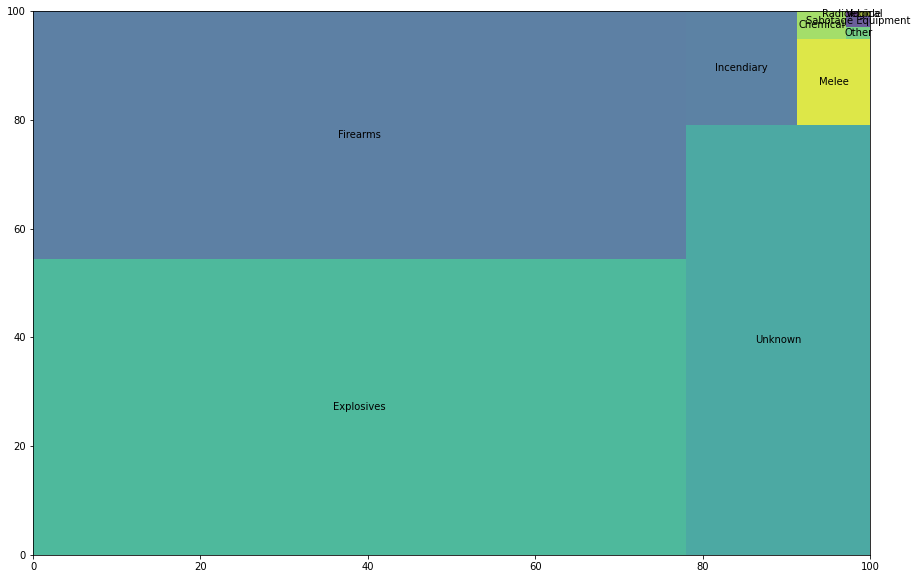

In [54]:
gname = "Taliban"
def treeplot(data,gname):
    plt.subplots(figsize=(15,10))
    w_t = pd.DataFrame(data[data['gname']==gname]['weaptype1_txt'].value_counts())
    w_t.reset_index(level=0,inplace=True)
    t = squarify.plot(sizes=w_t["weaptype1_txt"],label=w_t["index"],alpha=0.8)
    plt.show()
treeplot(data,"Taliban")

### 2.8 Most dangerous country
###### Now below is the bar graph of number of attacks for top 10 countries for year 2016. Looking at the graph it seems that Iraq is the most dangerous country to live in, then comes Afghanistan, India, Somalia, Turkey and rest. Well this graph is kind of misleading if we want to decide "most dangerous country". And by "most dangerous country" we have to decide a particular metric for "dangerous". That ofcourse can't be number of attacks. In other words we have to define what do we mean by "most dangerous" in terms of data we have.

###### It is like to decide out of given two boxes, one contains wood and other cotton, which is heavy. Ofcourse wood is heavier than cotton but here we dont consider dimensions of given boxes like volume or area. If we have information like 1000 cubic meter of cotton and 1 cubic meter of wood, than its easy to decide which one is heavy. Beacause we assigned a metric of Volume for "heavyness" of a box.

###### Similarly, to find out most dangerous country, we have to find number of attacks per 1000 people or 1,000,000 people beacuse thats more accurate metric for "most dangerous".

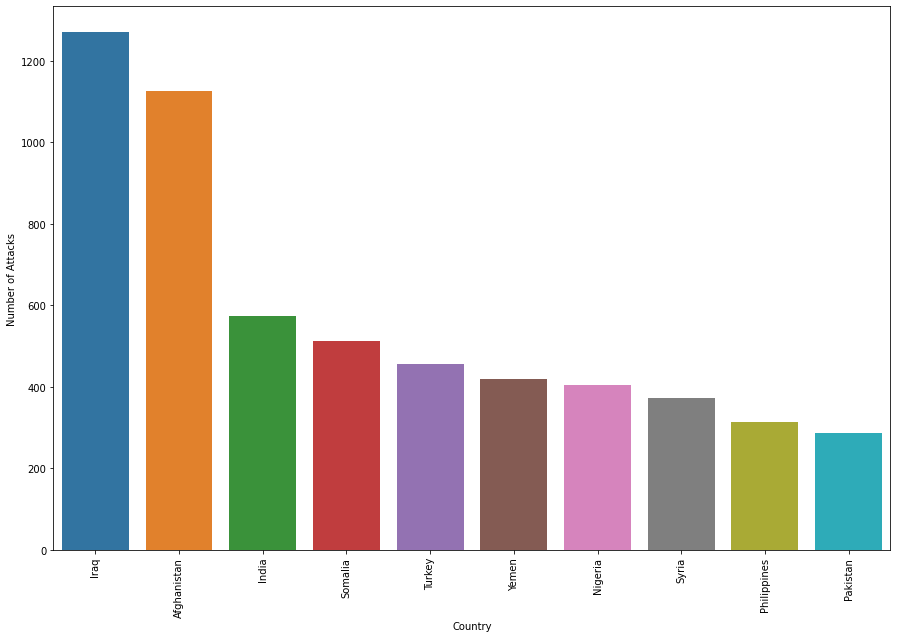

In [55]:
plt.subplots(figsize=(15,10))
d = data[data['iyear']==2016]
countries = pd.DataFrame(d['country_txt'].value_counts()[:10])
countries.reset_index(inplace=True)
countries.columns= ['Country','Number of Attacks']
# Prepare a pandas series for populations of these 10 countries, avaliable at https://en.wikipedia.org/wiki/List_of_countries_by_population_(United_Nations)
population = pd.Series([37202572,34656032,1324171354, 14317996, 79512426, 27584213, 20672987, 18430453, 103320222, 193203476])
countries2 = copy.deepcopy(countries)
countries['Number of Attacks'] = countries['Number of Attacks']/population*1000000
p1 = sns.barplot(countries2['Country'],countries2['Number of Attacks'],data= countries2)
p1.set_xticklabels(countries2['Country'],rotation=90)
plt.show(p1)

###### Now below is the graph that shows the most dangerous country in 2016. Here is the link to a blog (http://www.businessinsider.com/most-dangerous-countries-in-the-world-2016-6) by Business Insider and it shows 15 most dangerous countries. They have compared each country by peace index, unlike this notebook which only takes terrorism into account. But though results are pretty much same. So with below graph one can say that "Probability to die by terrorist attack" is highest in Somalia and least in India if you spawn in any of below 10 countries.

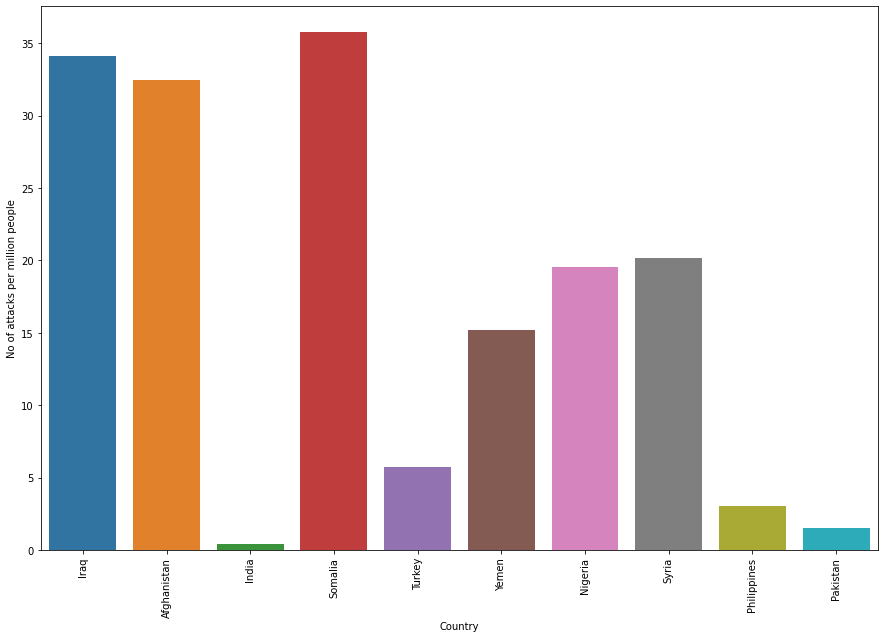

In [56]:
plt.subplots(figsize=(15,10))
countries.columns = ['Country','No of attacks per million people']
p2 = sns.barplot(countries['Country'],countries['No of attacks per million people'],data= countries)
p2.set_xticklabels(countries['Country'],rotation=90)
plt.show()


#### 2.8.2 Why most dangerous country is most dangerous?
###### Lets try to analyse above graph in depth.

In [58]:
def succ_fail(data,country):
    s = data[data['country_txt']==country]
    s2 = pd.DataFrame(s.groupby(['iyear','success'])['iyear'].count())
    s2.columns=['count']
    s2.reset_index(inplace=True)
    s2["dummy"]=0
    color_set2 = ['#f71325','#20d813']
    p = sns.tsplot(time='iyear',value='count',condition='success',data=s2,unit='dummy',color = sns.color_palette(color_set2))
    p.set_title(country)
    p.set_ylabel("Number of Attacks")
    p.set_xlabel("Year")
    plt.show()
    #print (s2.head())



### 3. Prediction of groups responsible for the attack
###### Tree based models are used here for prediction because they are more robust to outliers, and as we have many outliers in spite of clipping the dataset, tree based models is the best bet we have! This is because, models like Logistic Regression or Neural Networks are very sensitive to outliers; consider a training scenario in a backpropagation network. Before backpropagating the error, all the error values are added together. The thing to notice is that error is averaged (divided by number of rows in dataset). So after few epochs the error due to rare classes turns out to be very low after averaging it. Due to which the network is unable to capture the error contributed by rare classes which makes them difficult to learn them. One way to learn such classes is that we can "penalize" the misclassified class, so that it will contribute more to overall error. Which is not the case with tree based models, beacause they literally dont look at how far is a data point. All they look is the "INFORMATION GAIN" (or decrease in RANDOMNESS of data) by splitting an attribute, which has more to do with how better it can classify target variable.

###### Moreover tree based models are fast learning algorithms and dataset given is also huge, it is advisable to use them. So, lets try tree based models: Random Forest, Decision Tree and Gradient Boosting Machines.

#####Here we have a multi-class classification problem. So f1 score is used as an evaluation metric with micro average. The dataset is highly skewed in terms of number of classes. So "macro average" will be a biased score as it is just average of individual Precision and Recall scores for each class, i.e., for classes with high frequency will have higher scores as compared to other classes which results in biased overall score.

###### Whereas with micro averaged score, the performance (Precision or Recall) is calculated from individual True Positive, True Negative, False Positive, False Negative. This elimintaes the biasness of performance scores by classes with high frequency.



In [61]:
rf = RandomForestClassifier(n_estimators=50, class_weight='balanced')
tree = DecisionTreeClassifier(criterion="entropy")
gbm = GradientBoostingClassifier(learning_rate=0.2, max_depth=8)
def predict(model,train,y_train,test,y_test):
    model.fit(train,y_train)
    yhat = model.predict(test)
    return f1_score(y_test,yhat,average='micro')

In [62]:
print ("We removed",round((sum(class_freq) - sum(class_freq[:threshold]))/sum(class_freq)*100,2),"% of data as outliers. Below are prediction scores, it will decrease as we increase the threshold value (or include classes with less frequency in data)")

We removed 7.36 % of data as outliers. Below are prediction scores, it will decrease as we increase the threshold value (or include classes with less frequency in data)


In [63]:
print ("F1-Score by Random Forest, threshold =",threshold ,":" ,predict(rf,train, y_train, test, y_test))

F1-Score by Random Forest, threshold = 500 : 0.840126898673332


In [64]:
print ("F1-Score by Decision Tree, threshold =",threshold ,":" ,predict(tree,train, y_train, test, y_test))

F1-Score by Decision Tree, threshold = 500 : 0.8038838684868295


In [65]:
print ("F1-Score by Gradient Boosting Machine, threshold =",threshold ,":" ,predict(tree,train, y_train, test, y_test))

F1-Score by Gradient Boosting Machine, threshold = 500 : 0.8034993270524899


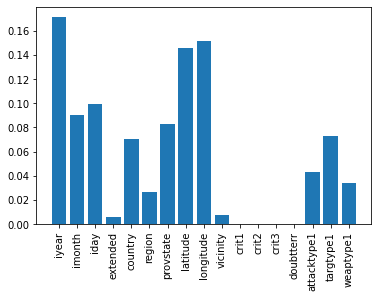

In [66]:
plt.bar(train.columns,rf.feature_importances_)
plt.xticks(rotation=90)
plt.show()

Location and time attributes play crucial role for predicting terrorist groups.

4. Neural Network

In [67]:
from sklearn.neural_network import MLPClassifier

In [68]:
threshold = 200
train, y_train, test, y_test = prep(data,threshold)

In [69]:
nn = MLPClassifier(activation='relu',alpha=0.01,hidden_layer_sizes=(20,10))

In [70]:
print ("F1-Score by Neural Network, threshold =",threshold ,":" ,predict(nn,train, y_train, test, y_test))

F1-Score by Neural Network, threshold = 200 : 0.6632685233841303


As you can see, even with 2 hidden layers the network didn't perform upto the mark. This is because the data available is not sufficient for the network to learn the rare classes, which is handled very well by above tree based models.

5. Challenges
The dataset countains huge number of classes (3,453) and the frequency of each class ranged from 1 to about 6,575; which lead to removal of few classes that had frequency less than a particular number. This clipping has to be done by setting "class_freq [threshold] = 11" i.e., classes with frequency less than 11 are removed. Decreasing this number will lead to better classification results. It was necessary to come up with a number that can include as much number of classes yet provide better and acceptable classification results.

The "Folium" API is used for chloropleth world map. The way it works is, it maps the country names with its corresponding geographic shape written in JSON, and then assigns the intensity of color with variable (number of kills, number of attacks etc). In order to make the mapping it was necessary to make sure that country text in the databse match with that of API. There were certain countries which had different names, for example : The database had "United States" but the API had "United States of America"; database had "East Germany", "West Germany" which in today's date are known as "Germany" so API had only "Germany". So these kind of data irregularities were resolved manually looking for each match in database and API.

6. Future Work
As discussed in Section 3., we can use a neural network that penalizes the misclassified classes, so that it can capture and learn the rare classes as well.

Given that we have learned the activities by almost all terrorist groups, can we predict the next move of such groups at given time and location? Such a task will require rigorous time series analysis and maybe more attributes to learn, like weather conditions, government body, economic status etc.

----------------End of the code---------------

********THANK YOU********